In [46]:
import numpy as np
from ase.io import read
from abtem import *

# Scan and detect

Scanning imaging modes such as STEM works by rastering an electron probe across a sample pixel by pixel, and recording the scattering signal. As in earlier tutorials, we start by importing our graphene atoms and creating a probe, here at 80 keV.

In [47]:
atoms = read('data/orthogonal_graphene.cif') 

probe = Probe(energy=80e3, semiangle_cutoff=30, focal_spread=60, defocus=50)

potential = Potential(atoms, sampling=.04)

## Line scan

The `LineScan` function scans the probe along a straight line between two points with a spacing given by the `gpts` parameter.

Below we create a linescan object to scan between two atoms, and run a multislice simulation to get the corresponding exit wave. The scan objects can be given as an argument of the plotting method of 2D arrays or the `show_atoms` function to visualise the scan region.

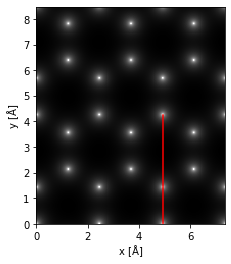

In [48]:
from abtem.scan import LineScan

linescan = LineScan(start=[2 * np.sqrt(3) * 1.42, 0], end=[2 * np.sqrt(3) * 1.42, 3 * 1.42], gpts=40, endpoint=False)

ax, im = potential.project().show()
linescan.add_to_mpl_plot(ax)

In [49]:
line_exit_probes = probe.multislice(positions=linescan.get_positions(), potential=potential)

## Detect

In real experiments, the exit probes are not directly detected. Correspondingly, in abTEM the way a signal is detected is controlled by detector objects. There are several different types of detectors, but for now we focus on the basic `AnnularDetector`, which depending on the choice of integration region can represent the detector used in bright-field, medium- or high-angle annular dark-field microscopy. The integration region is given by an inner and outer radius in mrad; below we create three different types of detectors, and plot their respective integration regions.

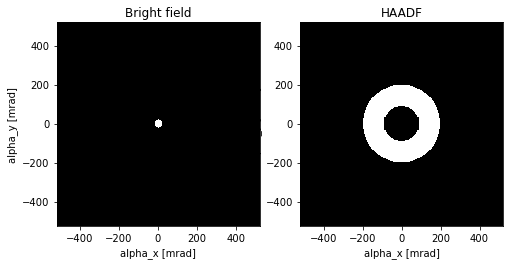

In [50]:
from abtem.detect import AnnularDetector
import matplotlib.pyplot as plt

bright = AnnularDetector(inner=0, outer=20)
haadf = AnnularDetector(inner=90, outer=200)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))

bright.show(probe, ax=ax1, title='Bright field')
haadf.show(probe, ax=ax2, title='HAADF');

The probes can be detected using the `.detect` method, this condenses each probe down to a single integrated intensity.

In [51]:
haadf.detect(line_exit_probes)

array([2.01043091e-04, 1.96584791e-04, 1.84240314e-04, 1.66724247e-04,
       1.47861894e-04, 1.31806155e-04, 1.22136553e-04, 1.21057317e-04,
       1.28894317e-04, 1.44012709e-04, 1.63181583e-04, 1.82292322e-04,
       1.97260524e-04, 2.04878466e-04, 2.03431890e-04, 1.92936146e-04,
       1.74967965e-04, 1.52167588e-04, 1.27574982e-04, 1.03979604e-04,
       8.34414750e-05, 6.70754744e-05, 5.50918521e-05, 4.70271116e-05,
       4.20563301e-05, 3.92923030e-05, 3.80103447e-05, 3.77825272e-05,
       3.85396634e-05, 4.05770297e-05, 4.45109872e-05, 5.11725193e-05,
       6.14165328e-05, 7.58522074e-05, 9.45333159e-05, 1.16694006e-04,
       1.40634496e-04, 1.63841003e-04, 1.83366457e-04, 1.96421810e-04],
      dtype=float32)

The typical syntax for simulating a STEM experiment requires giving the detector(s) as an argument of the scan object.

In [52]:
measurements = probe.scan(linescan, [haadf, bright], potential, pbar=True)

The output is a list of measurements with one entry per detector, e.g. the bright-field one.

In [53]:
measurements[0]

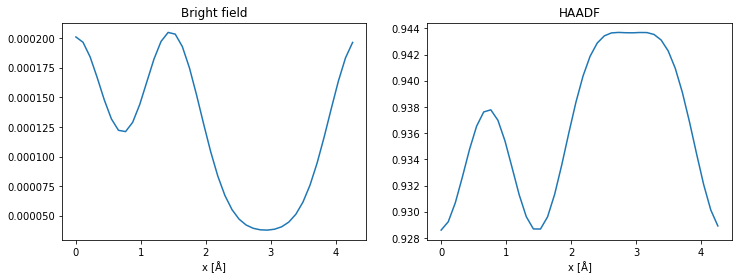

In [54]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12, 4))
measurements[0].show(ax=ax1, title='Bright field')
measurements[1].show(ax=ax2, title='HAADF');

We can write a measurement to disk into an .hdf5 file.

In [55]:
measurements[0].write('data/linescan.hdf5')

'data/linescan.hdf5'

## Grid scan

The `GridScan` object is used essentially the same as the `LineScan` object, except the start and end coordinates now denote the corners of the grid. In the following, we scan over a tileable section of the potential. By specifying an output file for the detector, we write the measurements directly to disk as they are made.

We set the probe step size (or sampling) slightly better than the Nyquist frequency of the probe contrast transfer function. The resulting image will be quite pixelated, however, we can use interpolation to improve the sampling.

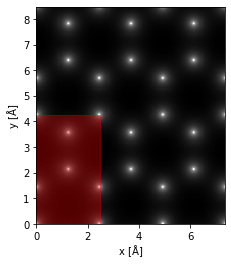

In [56]:
from abtem.scan import GridScan

detector = AnnularDetector(inner=86, outer=190, save_file='data/gridscan.hdf5')
gridscan = GridScan(start=[0, 0], end=[np.sqrt(3) * 1.42, 3 * 1.42], sampling=probe.ctf.nyquist_sampling * .9)

ax, im = potential.project().show();

gridscan.add_to_mpl_plot(ax)

The number of positions in a densely sampled grid can obviously be large and the calculation take some time, hence it may be useful to show the progress as below.

In [57]:
measurement_files = probe.scan(gridscan, [detector], potential, pbar=True)

We read back the measurements from disk and tile the image.

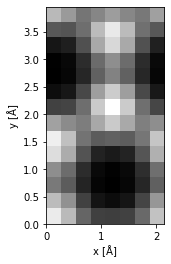

In [58]:
from abtem.measure import Measurement

measurement = Measurement.read('data/gridscan.hdf5')
measurement.show();

The pixel size in the image is set by our sampling, which affects the computational cost of the calculation. The resulting images can be tiled and smoothed by interpolating values between the pixels (here with a virtual sampling of $0.04$ Å).

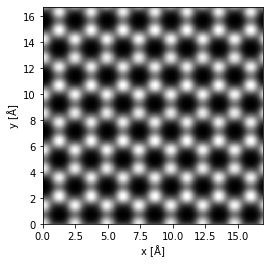

In [59]:
new_measurement = measurement.tile((7, 4))
new_measurement = new_measurement.interpolate(.04)

new_measurement.show();

It is not possible to save to disk during the scan, but it is straightforward to export the measurement as an image.

In [60]:
new_measurement.save_as_image('data/gridscan.tif')